# Librerías 

In [1]:
import os
from tqdm import tqdm
from time import time

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from skimage.exposure import equalize_hist

from skimage.transform import integral_image
from skimage.feature import haar_like_feature, haar_like_feature_coord

from sklearn.feature_selection import SelectPercentile, f_classif

import zipfile
import os

from random import sample
from skimage.transform import resize
from skimage import data, color
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.metrics import precision_score, f1_score, make_scorer

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Datos

**Imágenes de rostros para entrenamiento:**
* formato .pgm
* 64 x 64 píxeles
* 0 - 255 rango de valores
* N = 12833 imágenes


**Imágenes de test (rostros y fondos sin etiquetar):**
* formato .pgm
* 19 x 19 píxeles
* 0 - 255 rango de valores
* N = 7920 imágenes 

In [2]:
# # colab
# !unzip /content/CBCL.zip
# !tar -xvzf /content/face.test.tar.gz
# !tar -xvzf /content/face.train.tar.gz

# # vscode
dataset_file = 'content/obligatorio-mlia-2024.zip'
background_file = 'content/background.zip'

dataset_extract_path = 'content/obligatorio-mlia-2024'
background_extract_path = 'content/background'

os.makedirs(background_extract_path, exist_ok=True)
os.makedirs(dataset_extract_path, exist_ok=True)

with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
    zip_ref.extractall(dataset_extract_path)

with zipfile.ZipFile(background_file, 'r') as zip_ref:
    zip_ref.extractall(background_extract_path)


In [3]:
suffix = '.pgm'

faces = os.listdir(f'{dataset_extract_path}/Faces/Faces')
faces = [filename for filename in faces if filename.endswith(suffix)]

print(f'# Faces: {len(faces)}')


# Faces: 12833


In [4]:
# Tamaño de las imágenes de rostros
size = (19,19)

def get_faces_subset(n_faces):
    sample_faces = sample(faces, n_faces)

    im_faces = []
    for filename in tqdm(sample_faces):
        path = f'{dataset_extract_path}/Faces/Faces/' + filename
        with open(path, 'rb') as pgmf:
            image = plt.imread(pgmf)
            image = resize(image, size)
        im_faces.append(image)
    return im_faces


In [5]:
n_faces_subset_one = 1000
im_faces = get_faces_subset(n_faces_subset_one)

100%|██████████| 1000/1000 [00:03<00:00, 260.35it/s]


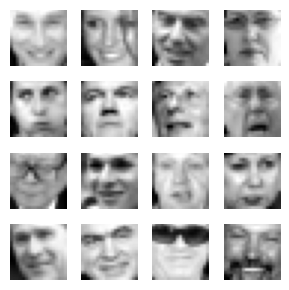

In [6]:
# Visualización de las imágenes de rostros
K = 16
indices = sample(range(n_faces_subset_one),k=K)

fig, ax = plt.subplots(4, 4, figsize=(3, 3), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

for i in range(K):
    idx = indices[i]
    image = im_faces[idx]
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

In [7]:
# Tomamos algunas imágenes de sklearn
imgs_skimage = ['text',
                'coins',
                'moon',
                'page',
                'clock',
                'immunohistochemistry',
                'chelsea',
                'coffee',
                'hubble_deep_field'
                ]

backgrounds_big = []
for name in imgs_skimage:
    image = getattr(data, name)()
    if len(image.shape) == 3 and image.shape[2] == 3:  # Chequeamos si la imagen es RGB
        image = color.rgb2gray(image)
    backgrounds_big.append(image)

# Imagenes de fondo adicionales
for i in range(31):
    filename = f'{background_extract_path}/' + str(i) + '.jpg'
    image = plt.imread(filename)
    image = color.rgb2gray(image)
    backgrounds_big.append(image)

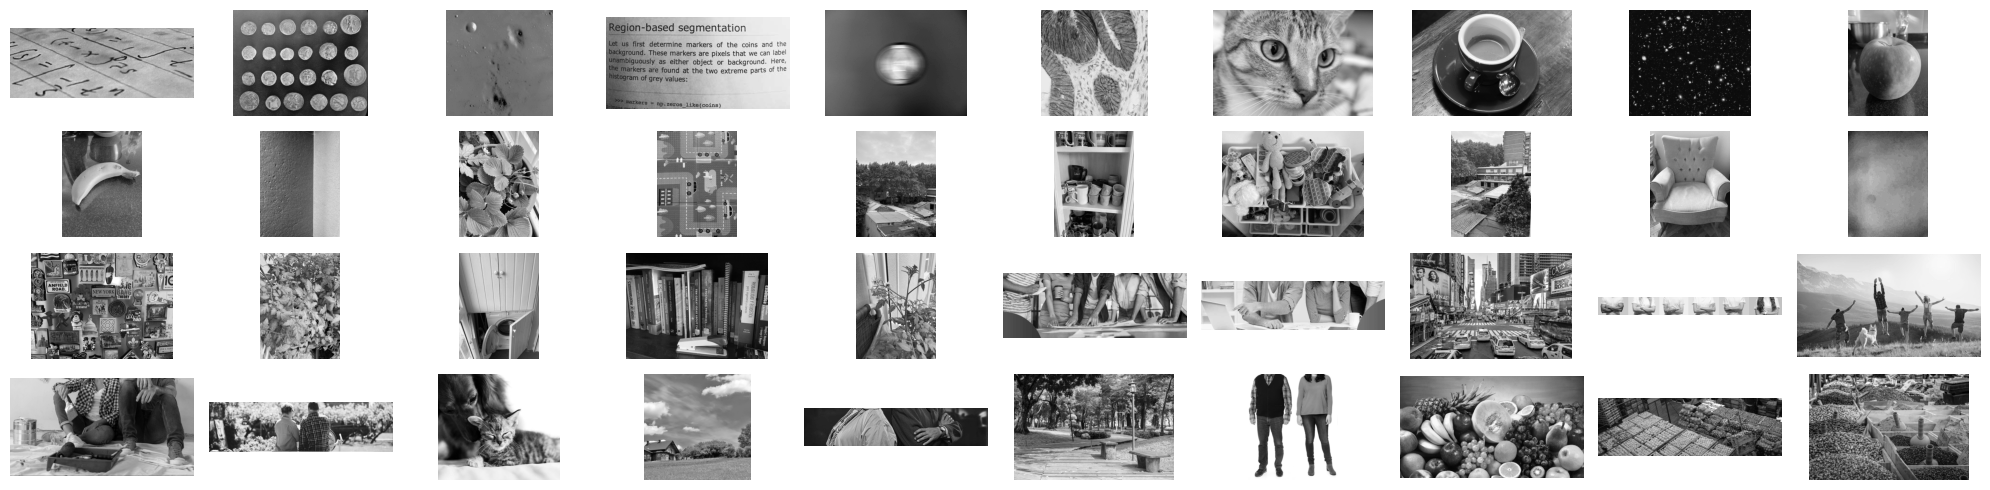

In [8]:
# Visualización de las imágenes de fondos
fig, ax = plt.subplots(4, 10, figsize=(20, 5), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

for i in range(len(backgrounds_big)):
    image = backgrounds_big[i]
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()

In [9]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=size, random_state=0):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    H = img.shape[0]
    W = img.shape[1]
    H_patch = min(H , int(scale * patch_size[0]))
    W_patch = min(W , int(scale * patch_size[1]))
    extracted_patch_size = (H_patch, W_patch)

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=random_state)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches


In [10]:
def get_backgrounds_subset(proportion, n_faces):
    # Extraer parches de las imágenes de fondo
    scales = [1,1.5,2,2.5]

    num_patches = int((proportion * n_faces)/(len(scales) * len(backgrounds_big)))

    im_backgrounds = np.vstack(
        [extract_patches(im_bkgnd, num_patches, scale, random_state=42)
        for im_bkgnd in tqdm(backgrounds_big)
        for scale in scales]
        )
    return im_backgrounds

In [11]:

im_backgrounds = get_backgrounds_subset(3, n_faces_subset_one)

print(f'# Back: {len(im_backgrounds)}')

100%|██████████| 40/40 [00:00<00:00, 126.18it/s]

# Back: 2880


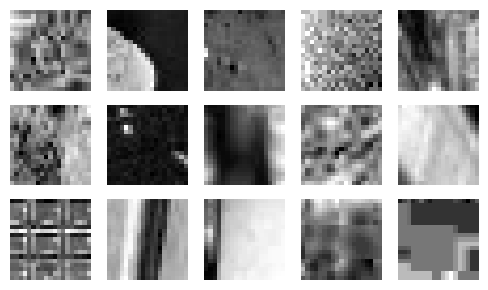

In [12]:
# Visualización de una muestra
fig, ax = plt.subplots(3, 5, figsize=(5,3))
for i, axi in enumerate(ax.flat):
    axi.imshow(im_backgrounds[100 * i], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

In [13]:
im_faces = np.array(im_faces)

print(f'Faces shape: {im_faces.shape}')
print(f'Backgrounds shape: {im_backgrounds.shape}')

Faces shape: (1000, 19, 19)
Backgrounds shape: (2880, 19, 19)


In [14]:
Im_train = np.vstack([im_faces, im_backgrounds])
print(f'Images shape: {Im_train.shape}')

Images shape: (3880, 19, 19)


In [15]:
y_train = np.array([1]*len(im_faces)+[0]*len(im_backgrounds))
print(f'y_train shape: {y_train.shape}')

y_train shape: (3880,)


# Histogram equalization

In [16]:
# Im_train_split, Im_test_split, y_train_split, y_test_split = train_test_split(Im_train,
#                                                       y_train,
#                                                       test_size=0.2,
#                                                       shuffle=True,
#                                                       stratify=y_train,
#                                                       random_state = 42)

In [17]:
# print(f'Im_train shape: {Im_train_split.shape}')
# print(f'Im_test shape: {Im_test_split.shape}')
# print(f'y_train shape: {y_train_split.shape}')
# print(f'y_test shape: {y_test_split.shape}')

In [18]:
# Normalización de las imágenes de entrenamiento y prueba
Im_train_norm = [equalize_hist(image) for image in Im_train]
# Im_test_norm = [equalize_hist(image) for image in Im_test_split]

In [19]:
def extract_feature_image(img, feature_type=None, feature_coord=None):
    """Extrae las Haar features de la imagen"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

In [20]:
X_train = [extract_feature_image(img) for img in tqdm(Im_train_norm)]
X_train = np.array(X_train)

100%|██████████| 3880/3880 [05:04<00:00, 12.74it/s]


In [21]:
# X_test = [extract_feature_image(img) for img in tqdm(Im_test_norm)]
# X_test = np.array(X_test)

In [22]:
# Pueden guardar la matriz si lo desean TODO
np.save('X_train', X_train)

In [23]:
# Y cargarla posteriormente TODO
X_train = np.load('X_train.npy')

In [24]:
X_train.shape

(3880, 63960)

In [25]:
def classifierOptimizer(classifier_name, X_train, y_train, param_dist, classifier):
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score),
        'f1': make_scorer(f1_score)
    }

    random_search = RandomizedSearchCV(estimator=classifier,
                                    param_distributions=param_dist,
                                    n_iter=25,
                                    cv=2,
                                    scoring=scoring,
                                    refit='f1',
                                    verbose=3,
                                    n_jobs=8)

    random_search.fit(X_train, y_train)
    cv_results = random_search.cv_results_
    best_model = random_search.best_estimator_

    # Obtener la importancia de las features del mejor modelo
    features_indexes = None
    if classifier_name == 'Logistic Regression':
        feature_importances = best_model.coef_[0]
        # Seleccionar las 200 mejores features
        features_indexes = np.argsort(np.abs(feature_importances))[-200:]
    elif classifier_name == 'Neural Network':
        feature_importances = np.abs(best_model.coefs_[0]).sum(axis=1)
        features_indexes = np.argsort(feature_importances)[-200:]
    else:
        feature_importances = best_model.feature_importances_
        features_indexes = np.argsort(feature_importances)[-200:]

    print("Mejor modelo:", best_model)
    print("cv_results:", cv_results)
    print("Mejores hiperparámetros:", random_search.best_params_)
    # Imprimir los resultados del F1 score para cada iteración
    cv_results = random_search.cv_results_

    best_results = {
        'f1': cv_results['mean_test_f1'][random_search.best_index_],
        'accuracy': cv_results['mean_test_accuracy'][random_search.best_index_],
        'precision': cv_results['mean_test_precision'][random_search.best_index_],
        'params': cv_results['params'][random_search.best_index_]
    }

    print("---")
    print(f"Iteración con mejor F1 Score para {classifier_name}:")
    print(f"Parámetros: {best_results['params']}") #TODO: mejorar el print
    print(f"Accuracy (entrenamiento): {best_results['accuracy']}")
    print(f"Precision (entrenamiento): {best_results['precision']}")
    print(f"F1 Score (entrenamiento): {best_results['f1']}")
    print("---")

    return best_model, features_indexes, best_results


## Random Forest - Ronda 1 de entrenamiento

In [26]:
param_dist_rf = {
        'n_estimators': randint(50, 200),
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

best_rf_model, features_indexes_rf, best_rf_results = classifierOptimizer("Random Forest", X_train, y_train, param_dist_rf, RandomForestClassifier(random_state=42))


Fitting 2 folds for each of 25 candidates, totalling 50 fits
Mejor modelo: RandomForestClassifier(bootstrap=False, min_samples_leaf=2, n_estimators=167,
                       random_state=42)
cv_results: {'mean_fit_time': array([62.8931061 , 21.83621514, 24.36900651, 38.17900622, 15.49274957,
       68.25908399, 25.86583316, 18.2562139 , 34.81599176,  4.27138937,
       48.84800422, 16.70899773, 27.69599366,  4.47232425, 19.65649891,
       39.95996201,  2.09007967,  2.73778582,  4.00651956,  4.17917812,
        2.6989398 , 25.79255497, 18.2991848 ,  5.1260004 ,  2.59102416]), 'std_fit_time': array([0.07535708, 0.38368189, 0.17695272, 0.05107033, 0.24660075,
       0.24971509, 0.62724078, 0.05093503, 0.29462445, 0.08904207,
       0.00801766, 0.3586123 , 0.21472907, 0.00475919, 0.63984156,
       1.34078848, 0.08859932, 0.05380487, 0.07633138, 0.04677308,
       0.10386634, 0.18357408, 0.09012079, 0.03406739, 0.04931259]), 'mean_score_time': array([0.39639866, 0.34618843, 0.31838155, 

In [27]:
params_dist_gb = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.05, 0.001],
    'max_depth': [3, 4, 5, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'subsample': [0.8, 0.9, 1.0]
}

best_gb_model, features_indexes_gb, best_gb_results = classifierOptimizer("Gradient Boosting", X_train, y_train, params_dist_gb, GradientBoostingClassifier(random_state=42))

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Mejor modelo: GradientBoostingClassifier(max_features='log2', min_samples_leaf=2,
                           n_estimators=199, random_state=42)
cv_results: {'mean_fit_time': array([  4.97109032,  79.19819009,   4.54108799,   3.16901004,
         5.33753991,   3.88021672,   4.65769553,   6.17305887,
        79.86224139,  36.36387992,   2.24883425,  11.07055235,
       164.95878553,   2.74431992,  23.23611307, 139.965608  ,
         2.15982282,   2.82949853,   2.87374175,  15.15313327,
        17.60483038,  54.17896938,  35.77311039,   2.95499456,
       154.54091907]), 'std_fit_time': array([3.92575264e-02, 9.71946597e-01, 6.71231747e-03, 1.00028515e-03,
       1.72736645e-02, 1.20142698e-02, 7.51354694e-02, 2.28484869e-02,
       4.13475156e-01, 7.79082775e-02, 4.01011705e-02, 3.77209187e-02,
       1.52201819e+00, 2.25090981e-03, 1.67151928e-01, 1.95386398e+00,
       2.62805223e-02, 6.42528534e-02, 2.90504694e-02, 5.6060910

In [28]:
params_dist_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

best_dt_model, features_indexes_dt, best_dt_results = classifierOptimizer("Decision Tree", X_train, y_train, params_dist_dt, DecisionTreeClassifier(random_state=42))

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Mejor modelo: DecisionTreeClassifier(criterion='entropy', min_samples_leaf=4, random_state=42)
cv_results: {'mean_fit_time': array([ 1.89743662,  1.93623388,  2.16425228,  1.90619445, 56.19903684,
        2.36148858,  2.38081193,  2.29445863,  2.19052076,  2.13470864,
       88.25154829,  1.61879933,  1.63345706,  1.88729024,  1.53200114,
        1.52000713,  1.62266803,  1.46426356,  1.78580344,  1.42435491,
       74.71650124,  1.58004725,  1.65008008,  1.61827755,  1.4518683 ]), 'std_fit_time': array([1.66893005e-06, 9.78623629e-02, 6.30822182e-02, 2.57792473e-02,
       4.52343059e+00, 6.83250427e-02, 9.57727432e-04, 2.72428989e-02,
       7.73406029e-02, 3.50348949e-02, 2.06463082e+01, 2.24171877e-02,
       2.57955790e-02, 2.04753876e-03, 5.53869009e-02, 6.08491898e-02,
       3.72996330e-02, 5.79999685e-02, 1.35251641e-01, 4.25970554e-03,
       1.33471971e+01, 5.34664392e-02, 9.24063921e-02, 6.98018074e-03,
       3.0

In [29]:
params_dist_lr = {
    'loss': ['log_loss'],  # Solo para regresión logística
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': uniform(0.0001, 0.001),
    'max_iter': randint(1000, 2000),
    'tol': [1e-3, 1e-4, 1e-5],
}

best_lr_model, features_indexes_lr, best_lr_results = classifierOptimizer("Logistic Regression", X_train, y_train, params_dist_lr, SGDClassifier(random_state=42))

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Mejor modelo: SGDClassifier(alpha=np.float64(0.0006521190073845727), loss='log_loss',
              max_iter=1570, penalty='l1', random_state=42, tol=0.0001)
cv_results: {'mean_fit_time': array([ 80.26726067,   7.29035807, 411.92124093,  29.65107822,
         7.20479655,  31.11522222,  26.68845558,  28.10450673,
        24.25320411,  26.32111192,  31.83388591, 444.57017601,
       402.7559557 ,   5.70876086, 205.54386926,   5.81223941,
         5.62767029,  61.18987298,   5.69144714,  30.81210613,
       130.94695616,   5.74834526,  49.15490746,   5.90121436,
        30.6284554 ]), 'std_fit_time': array([3.85626582e+01, 6.09613657e-01, 3.48170957e+02, 1.25920341e+01,
       6.71167612e-01, 5.16293550e+00, 1.45970974e+01, 1.78931236e-01,
       6.56137347e+00, 7.85724807e+00, 7.09150720e+00, 1.54353859e+02,
       2.87716026e+02, 1.79561496e-01, 8.98270190e+01, 5.58427334e-01,
       3.59821320e-01, 6.66327238e+00, 4.90207314e

In [30]:
params_dist_mlp = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': uniform(0.0001, 0.001),
    'learning_rate': ['constant','adaptive'],
    'max_iter': randint(1000, 2000)
}

best_mlp_model, features_indexes_mlp, best_mlp_results = classifierOptimizer("Neural Network", X_train, y_train, params_dist_mlp, MLPClassifier(random_state=42))

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Mejor modelo: MLPClassifier(alpha=np.float64(0.00041649625315710496),
              hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive',
              max_iter=1421, random_state=42)
cv_results: {'mean_fit_time': array([ 175.79250085,  195.27842307, 1101.94116449,  880.92219412,
        207.48718834,  193.99335253,  209.91057706,  555.73983228,
        452.64201212,  202.14453733,  412.9856782 ,  169.76190782,
        203.91425359,  784.31994998, 1663.4320879 , 1391.35849237,
       1501.11650729,  166.76752424,  277.40282035,  210.87079644,
       1367.1388278 ,  175.99433756,  806.19219816,  529.54443717,
        164.0499841 ]), 'std_fit_time': array([ 76.46821892,  14.00538635,  71.00347805, 103.23271954,
        59.70811725,  18.50333583,  72.20045161,  22.49119318,
        85.10725474,  12.95347989,  66.59976459,  64.1477766 ,
        45.62796986, 401.49139011, 835.85452485, 933.64978886,
       167.77677059,   9.

## Subset 2 - Ronda 2 de entrenamiento

In [31]:
n_faces_subset_two = 5000
im_faces_two = get_faces_subset(n_faces_subset_two)

im_backgrounds_two = get_backgrounds_subset(3, n_faces_subset_two)

100%|██████████| 40/40 [00:00<00:00, 42.83it/s]


In [32]:
im_faces_two = np.array(im_faces_two)

print(f'Faces shape: {im_faces_two.shape}')
print(f'Backgrounds shape: {im_backgrounds_two.shape}')

Faces shape: (5000, 19, 19)
Backgrounds shape: (14880, 19, 19)


In [33]:
Im_train_two = np.vstack([im_faces_two, im_backgrounds_two])
print(f'Images shape: {Im_train_two.shape}')

Images shape: (19880, 19, 19)


In [34]:
y_train_two = np.array([1]*len(im_faces_two)+[0]*len(im_backgrounds_two))
print(f'y_train_two shape: {y_train_two.shape}')

y_train_two shape: (19880,)


In [35]:
Im_train_norm_two = [equalize_hist(image) for image in Im_train_two]

In [36]:
X_train_two = [extract_feature_image(img) for img in tqdm(Im_train_norm_two)]
X_train_two = np.array(X_train_two)

100%|██████████| 19880/19880 [24:11<00:00, 13.70it/s]


In [37]:
# Crear el objeto de evaluación para F1 score
f1_scorer = make_scorer(f1_score, average='binary') 

# Función para evaluar y obtener F1 scores
def evaluate_model(model, X_train, y_train, cv=2): #TODO: chequear el cv
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)
    print(f"F1 scores for {model.__class__.__name__}: {scores}")
    print(f"Average F1 score: {scores.mean()}")
    return scores

In [38]:
scores_rf = evaluate_model(best_rf_model, X_train_two[:, features_indexes_rf], y_train_two)

F1 scores for RandomForestClassifier: [0.95505618 0.96572581]
Average F1 score: 0.9603909931134469


In [39]:
scores_gb = evaluate_model(best_gb_model, X_train_two[:, features_indexes_gb], y_train_two)

F1 scores for GradientBoostingClassifier: [0.97087769 0.98032919]
Average F1 score: 0.9756034356743122


In [40]:
scores_dt = evaluate_model(best_dt_model, X_train_two[:, features_indexes_dt], y_train_two)

F1 scores for DecisionTreeClassifier: [0.93180447 0.94150867]
Average F1 score: 0.9366565693770947


In [41]:
scores_lr = evaluate_model(best_lr_model, X_train_two[:, features_indexes_lr], y_train_two)

F1 scores for SGDClassifier: [0.91688364 0.92133041]
Average F1 score: 0.9191070246802006


In [42]:
scores_mlp = evaluate_model(best_mlp_model, X_train_two[:, features_indexes_mlp], y_train_two)

F1 scores for MLPClassifier: [0.92249603 0.92848485]
Average F1 score: 0.9254904369610252


In [43]:
# TODO Seleccionar modelo

In [44]:
test_kaggle = os.listdir(f'{dataset_extract_path}/Test/Test')
test_kaggle = [filename for filename in test_kaggle if filename.endswith(suffix)]

print(f'# Test Kaggle: {len(test_kaggle)}')

# Test Kaggle: 7920


In [45]:
kaggle_id = []
im_test_kaggle = []

for filename in tqdm(test_kaggle):
    key = filename
    key = ''.join(key.split('test_', 1))
    key = ''.join(key.split('.pgm', 1))
    kaggle_id.append(key)
    path = f'{dataset_extract_path}/Test/Test/' + filename
    with open(path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        image = resize(image, size)
    im_test_kaggle.append(image)

100%|██████████| 7920/7920 [00:22<00:00, 347.62it/s]


In [46]:
im_test_kaggle_norm = [equalize_hist(im_test_kaggle[i]) for i in range(len(im_test_kaggle))]

In [47]:
feature_coord, feature_type = haar_like_feature_coord(width=19,
                                                      height=19,
                                                      )

In [48]:
X_test_kaggle = [extract_feature_image(img,
                                       feature_coord=None,
                                       feature_type=None
                                      ) for img in tqdm(im_test_kaggle_norm)]
X_test_kaggle = np.array(X_test_kaggle)

100%|██████████| 7920/7920 [09:15<00:00, 14.26it/s]


In [49]:
y_test_kaggle = best_gb_model.predict(X_test_kaggle) # TODO change model

In [50]:
y_test_kaggle.shape

(7920,)

In [51]:
submission_kaggle = pd.DataFrame({'id':kaggle_id, 'target_feature': y_test_kaggle})

In [52]:
submission_kaggle.to_csv('submission.csv',index=False)

In [ ]:
!pip install seaborn
!pip install pandas

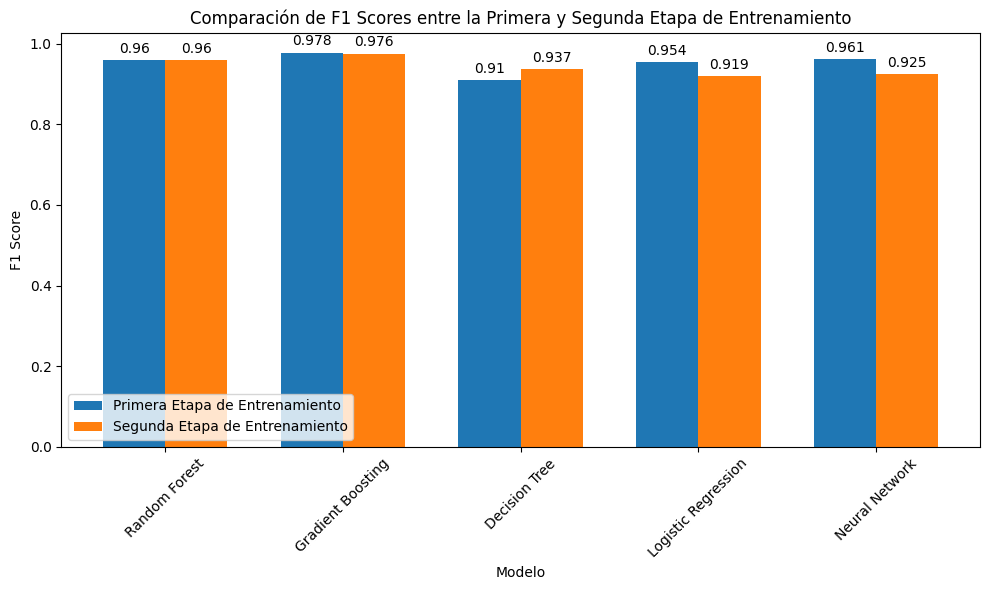

In [62]:
# F1 scores de la primera etapa de entrenamiento
f1_scores_first_stage = {
    "Random Forest": best_rf_results['f1'],
    "Gradient Boosting": best_gb_results['f1'],
    "Decision Tree": best_dt_results['f1'],
    "Logistic Regression": best_lr_results['f1'],
    "Neural Network": best_mlp_results['f1']
}

# F1 scores de la segunda etapa de entrenamiento
f1_scores_second_stage = {
    "Random Forest": scores_rf.mean(),
    "Gradient Boosting": scores_gb.mean(),
    "Decision Tree": scores_dt.mean(),
    "Logistic Regression": scores_lr.mean(),
    "Neural Network": scores_mlp.mean()
}

# Obtenemos los nombres de los modelos y los puntajes de F1
models = list(f1_scores_first_stage.keys())
first_stage_scores = list(f1_scores_first_stage.values())
second_stage_scores = list(f1_scores_second_stage.values())

x = np.arange(len(models))  # la ubicación de las etiquetas
width = 0.35  # el ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, first_stage_scores, width, label='Primera Etapa de Entrenamiento')
rects2 = ax.bar(x + width/2, second_stage_scores, width, label='Segunda Etapa de Entrenamiento')

# Añadimos texto para etiquetas, título y etiquetas personalizadas del eje x, etc.
ax.set_xlabel('Modelo')
ax.set_ylabel('F1 Score')
ax.set_title('Comparación de F1 Scores entre la Primera y Segunda Etapa de Entrenamiento')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

# Adjuntamos una etiqueta de texto encima de cada barra en rects, mostrando su altura.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 puntos de offset vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [64]:
!pip install ace_tools

ERROR: Could not find a version that satisfies the requirement ace_tools (from versions: none)
ERROR: No matching distribution found for ace_tools


In [75]:
# Creamos una lista con los resultados de los modelos
results = [
    {
        "Model": "Random Forest",
        "Precision": best_rf_results['precision'],
        "Accuracy": best_rf_results['accuracy'],
        "F1 Score": best_rf_results['f1'],
        "Parameters": best_rf_results['params']
    },
    {
        "Model": "Gradient Boosting",
        "Precision": best_gb_results['precision'],
        "Accuracy": best_gb_results['accuracy'],
        "F1 Score": best_gb_results['f1'],
        "Parameters": best_gb_results['params']
    },
    {
        "Model": "Decision Tree",
        "Precision": best_dt_results['precision'],
        "Accuracy": best_dt_results['accuracy'],
        "F1 Score": best_dt_results['f1'],
        "Parameters": best_dt_results['params']
    },
    {
        "Model": "Logistic Regression",
        "Precision": best_lr_results['precision'],
        "Accuracy": best_lr_results['accuracy'],
        "F1 Score": best_lr_results['f1'],
        "Parameters": best_lr_results['params']
    },
    {
        "Model": "Neural Network",
        "Precision": best_mlp_results['precision'],
        "Accuracy": best_mlp_results['accuracy'],
        "F1 Score": best_mlp_results['f1'],
        "Parameters": best_mlp_results['params']
    }
]

# Convertimos la lista de resultados en un DataFrame de pandas
results_df = pd.DataFrame(results)

# Imprimimos los resultados en el formato deseado
for index, row in results_df.iterrows():
    print(f"{row['Model']}\n{'-' * len(row['Model'])}")
    print(f"Precision: {row['Precision']}")
    print(f"Accuracy: {row['Accuracy']}")
    print(f"f1-score: {row['F1 Score']}")
    print("Parámetros:")
    for param, value in row['Parameters'].items():
        print(f"  {param}: {value}")
    print("\n")


Random Forest
-------------
Precision: 0.9762435326059116
Accuracy: 0.9798969072164948
f1-score: 0.9603636243457282
Parámetros:
  bootstrap: False
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 167


Gradient Boosting
-----------------
Precision: 0.9887724863308152
Accuracy: 0.9889175257731959
f1-score: 0.9782553187143164
Parámetros:
  learning_rate: 0.1
  max_depth: 3
  max_features: log2
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 199
  subsample: 1.0


Decision Tree
-------------
Precision: 0.9039692552097935
Accuracy: 0.9530927835051546
f1-score: 0.9097456757780443
Parámetros:
  criterion: entropy
  max_depth: None
  max_features: None
  min_samples_leaf: 4
  min_samples_split: 2


Logistic Regression
-------------------
Precision: 0.9503957294362729
Accuracy: 0.9760309278350515
f1-score: 0.9536335251987178
Parámetros:
  alpha: 0.0006521190073845727
  loss: log_loss
  max_iter: 1570
  penalty: l1
  tol: 0.0001


